# Bayesian logistic regression


In [1]:
import numpy as np
from tqdm import tqdm
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

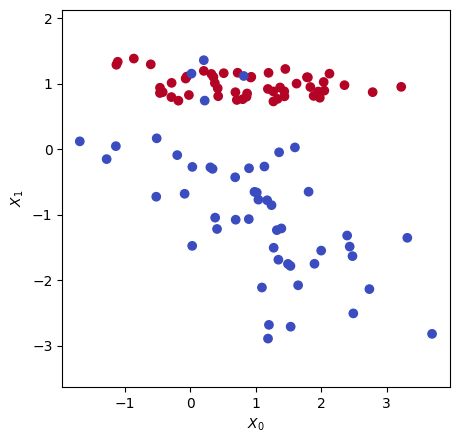

In [2]:
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, 
                           n_redundant=0, n_clusters_per_class=1, random_state=0)

plt.figure(figsize=(5, 5), dpi=100)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm')
plt.xlabel("$X_0$")
plt.ylabel("$X_1$")
plt.axis('equal')
plt.show()

$\text{P}(\theta|\mathfrak{D}) = \text{P}(\mathfrak{D}|\theta)\text{P}(\theta)$

$P(\theta \mid \mathfrak{D}) \propto P(\mathfrak{D} \mid \theta) P(\theta)$

$\alpha_i = \sigma(f(x_i, \theta))$

$y_i \sim \text{Bernoulli}(\alpha_i)$

$\text{P}(\mathfrak{D}|\theta) = \prod_1^n \text{P}(y_i|x_i, \theta)
= \prod_1^n \alpha_i^{y_i}(1-\alpha_i)^{1-y_i}$

Negative log likelihood

$\mathfrak{L}(\mathfrak{D}|\theta) = -\text{log P}(\mathfrak{D}|\theta)
= -\sum_{i=1}^n y_i \text{log} \alpha_i + (1-y_i)\text{log}(1-\alpha_i)$



In [3]:
theta = np.ones(X.shape[1]+1)
f = lambda X, theta: theta[0] + np.sum([X[:, i]*theta[i+1] for i in range(X.shape[1])], axis=0)
s = lambda z: 1/(1+np.exp(-z))
alpha = lambda X, theta: s(f(X, theta))
L = lambda X, theta: np.prod(np.power(alpha(X, theta), y)*np.power(1-alpha(X, theta), 1-y))
prior = lambda theta: np.prod(np.exp(-theta**2/(2*20)))
P = lambda theta: L(X, theta)*prior(theta)
P(theta)

8.572835335352942e-34

Left: P with a fixed variance 

Right: P with fixed $\theta_{0, 1}$ ($\beta_0$, $\beta_1$)

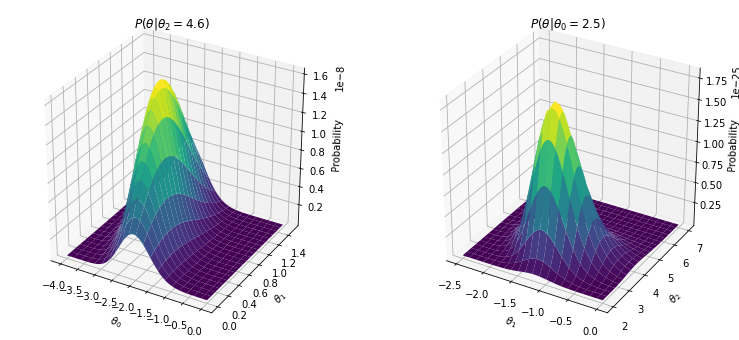

In [4]:
fig = plt.figure(figsize=(13, 6))
ax = fig.add_subplot(1, 2, 1, projection='3d')

xx, yy = np.meshgrid(np.linspace(-4, 0, 100), 
                     np.linspace(0, 1.5, 100))
coords = np.c_[xx.ravel(), yy.ravel(), np.ones((len(xx.ravel()), 1))*4.6]
Z = np.apply_along_axis(P, 1, coords)
Z = Z.reshape(xx.shape)

ax.plot_surface(xx, yy, Z, rstride=5, cstride=5, cmap='viridis')
ax.set_xlabel("$\\theta_0$")
ax.set_ylabel("$\\theta_1$")
ax.set_zlabel("Probability")
ax.set_title("$P(\\theta|\\theta_2=4.6)$")

ax = fig.add_subplot(1, 2, 2, projection='3d')

xx, yy = np.meshgrid(np.linspace(-2.5, 0, 100), 
                     np.linspace(2, 7, 100))
coords = np.c_[np.ones((len(xx.ravel()), 1))*2.5, xx.ravel(), yy.ravel()]
Z = np.apply_along_axis(P, 1, coords)
Z = Z.reshape(xx.shape)

ax.plot_surface(xx, yy, Z, rstride=5, cstride=5, cmap='viridis')
ax.set_xlabel("$\\theta_1$")
ax.set_ylabel("$\\theta_2$")
ax.set_zlabel("Probability")
ax.set_title("$P(\\theta|\\theta_0=2.5)$")
# MAP estimate for theta is [-2.46016029  0.80202231  4.64128239]

plt.show()

For estimating the distribution of parameters, we can run Metropolis-Hastings sampling.

In [5]:
def metropolis_hastings(func, x0, n_iter=1000, scale=0.2):
  samples = np.zeros((n_iter, len(x0)))
  accepted = np.zeros(n_iter)
  x = np.asarray(x0)
  for iteration in tqdm(range(n_iter), desc="Running Metropolis-Hastings sampling"):
    x_star = x + np.random.normal(scale=scale, size=len(x0))
    if np.random.rand() < func(x_star) / func(x):
      x = x_star
      accepted[iteration] = 1
    samples[iteration, :] = x
  return samples, accepted

In [6]:
n_burnin = 10000
n_samples = 60000
samples, accepted = metropolis_hastings(P, np.random.uniform(low=-10, high=10, size=3), n_iter=n_burnin+n_samples)

Running Metropolis-Hastings sampling: 100%|██████████| 70000/70000 [00:17<00:00, 3971.44it/s]


MAP estimate for theta is [-2.87269348  0.86230249  5.10414937]


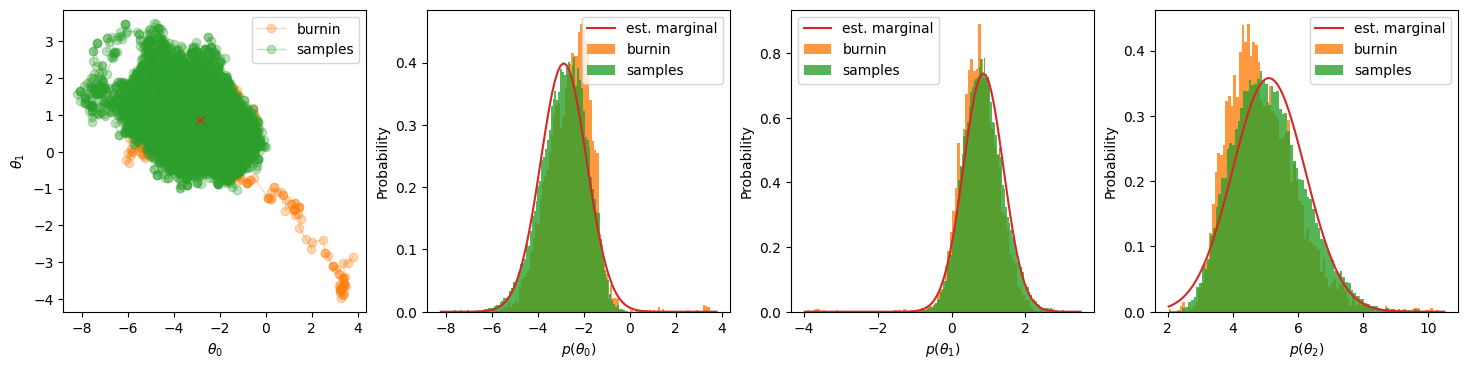

In [7]:
from scipy.stats import norm

theta_map = np.ones(3)

fig = plt.figure(figsize=(18, 4), dpi=100)
ax = fig.subplots(1, 4)
ax[0].set_xlabel("$\\theta_0$")
ax[0].set_ylabel("$\\theta_1$")
ax[0].plot(samples[:n_burnin, 0], samples[:n_burnin, 1], 'o-', color='C1', linewidth=1, label="burnin", alpha=.3)
ax[0].plot(samples[n_burnin:, 0], samples[n_burnin:, 1], 'o-', color='C2', linewidth=1, label="samples", alpha=.3)
ax[0].legend()
#plt.axis('equal')
for i in range(3):
  ax[i+1].set_xlabel("$p(\\theta_%i)$" % i)
  ax[i+1].set_ylabel("Probability")
  ax[i+1].hist(samples[:n_burnin, i], 100, color='C1', alpha=.8, density=True, label="burnin")
  ax[i+1].hist(samples[n_burnin:, i], 100, color='C2', alpha=.8, density=True, label="samples")
  x_plot = np.linspace(samples[:, i].min(), samples[:, i].max(), 100)
  dist = norm(np.mean(samples[n_burnin:, i]), np.std(samples[n_burnin:, i]))
  theta_map[i] = dist.mean()
  ax[i+1].plot(x_plot, dist.pdf(x_plot), 'C3', label="est. marginal")
  ax[i+1].legend()
ax[0].plot(theta_map[0], theta_map[1], 'x', color='C3', label="MAP $\theta$")
fig.show()
print("MAP estimate for theta is %s" % theta_map)

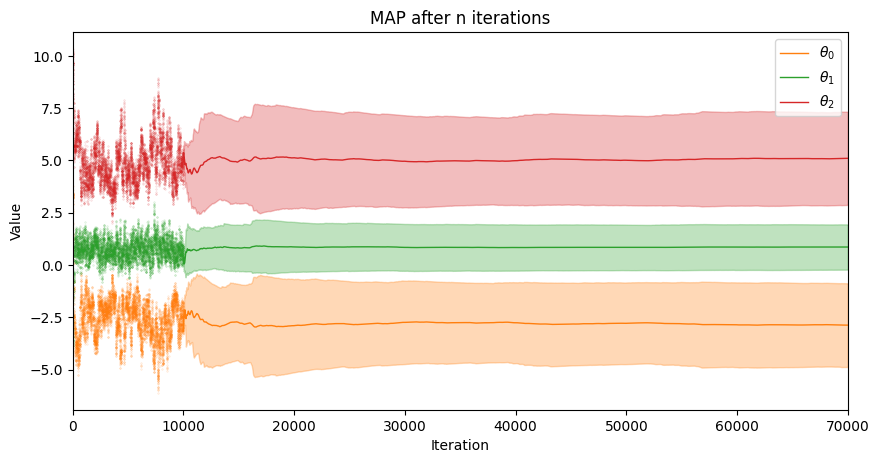

In [8]:
plt.figure(figsize=(10, 5), dpi=100)
x = np.arange(samples.shape[0])
for i in range(len(theta)):
  mu = np.asarray([np.mean(samples[n_burnin:n, i]) for n in range(n_burnin+1, samples.shape[0])])
  sigma = np.asarray([np.std(samples[n_burnin:n, i]) for n in range(n_burnin+1, samples.shape[0])])
  #plt.scatter(x[n_burnin:], samples[n_burnin:, i], c="C%i" % (i+1), s=1, alpha=.1, marker='x')
  plt.scatter(x[:n_burnin], samples[:n_burnin, i], c="C%i" % (i+1), s=1, alpha=.1, marker='x')
  plt.plot(x[n_burnin+1:], mu, color="C%i" % (i+1), linewidth=1, label="$\\theta_%i$" % i)
  plt.fill_between(x[n_burnin+1:], mu-2*sigma, mu+2*sigma, color="C%i" % (i+1), alpha=.3)
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.legend()
plt.title("MAP after n iterations")
a = list(plt.axis())
a[0] = 0
a[1] = n_samples+n_burnin
plt.axis(a)
plt.show()
# print(a)

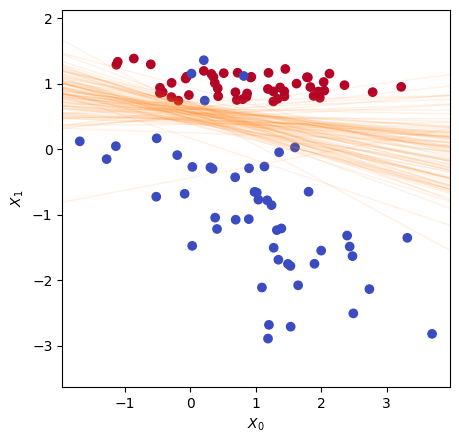

In [9]:
mu = np.mean(samples[n_burnin:, :], axis=0)
C = np.cov(samples[n_burnin:, :].T)
theta = np.random.multivariate_normal(mu, C)

fun = lambda x: (alpha(np.vstack(x).T, theta)[0]-.5)**2
from scipy.optimize import minimize

plt.figure(figsize=(5, 5), dpi=100)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm')
plt.xlabel("$X_0$")
plt.ylabel("$X_1$")
a = plt.axis('equal')
middle = np.asarray([a[0]+(a[1]-a[0])/2, a[2]+(a[3]-a[2])/2])

bounds = [(a[0], a[1]), (a[2], a[3])]
for i in range(100):
  theta = np.random.multivariate_normal(mu, C)
  normal = theta[1:]
  res = minimize(fun, middle, bounds=bounds)
  assert res.success
  if res.success:
    x = res.x
    n = np.asarray([1/normal[0], -1/normal[1]])
    n *= 10/np.linalg.norm(n)
    plt.plot([x[0]-n[0], x[0]+n[0]], [x[1]-n[1], x[1]+n[1]], color='C1', linewidth=1, alpha=.1)

plt.axis(a)
plt.show()